## SegCaps Experiments
This notebook was used in the development of the capsule network models and investigation of their performance.

In [42]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir)

import tensorflow as tf
from keras import layers, models
import numpy as np
import datetime
import mir_eval
#import capsnet

import dataset
import model_functions as mf
import audio_functions as af
import audio_models

import IPython.display as ipd
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['image.cmap'] = 'hot'
import importlib

In [43]:
importlib.reload(mf)

<module 'model_functions' from '/home/enterprise.internal.city.ac.uk/acvn728/MagPhaseMask/model_functions.py'>

In [44]:
#  Set variables
sample_rate=16384
n_fft=1024
fft_hop=256
patch_window=256
patch_hop=128
n_parallel_readers=16
normalise=True
batch_size = 1
shuffle=False
n_shuffle = 1
mag_phase = True
learning_rate = 0.0002
model_variant = 'unet'
data_type = 'mag'
phase_weight = 1
phase_loss_masking = 'binary'
phase_loss_approximation = False

checkpoint = '300/300-8'
model_base_dir = '/home/enterprise.internal.city.ac.uk/acvn728/checkpoints'

directory_a = '/home/enterprise.internal.city.ac.uk/acvn728/miniCHiME/Mixed'
directory_b = '/home/enterprise.internal.city.ac.uk/acvn728/miniCHiME/Voice'
directory_c = '/home/enterprise.internal.city.ac.uk/acvn728/miniCHiME/Background'

#directory_a = 'C:/Users/Toby/MSc_Project/Test_Audio/miniCHiME/Mixed'
#directory_b = 'C:/Users/Toby/MSc_Project/Test_Audio/miniCHiME/Voice'
#directory_c = 'C:/Users/Toby/MSc_Project/Test_Audio/miniCHiME/Background'


#  Create the pipeline
tf.reset_default_graph()
data = dataset.zip_files(directory_a, directory_b, directory_c)
data = dataset.get_paired_dataset(data,
                                  sample_rate,
                                  n_fft,
                                  fft_hop,
                                  patch_window,
                                  patch_hop,
                                  n_parallel_readers,
                                  batch_size,
                                  n_shuffle,
                                  normalise)

#  Create the iterator
pipe = data.make_initializable_iterator()
mixed_spec, voice_spec, background_spec, mixed_audio, voice_audio, background_audio = pipe.get_next()

#  Create variable placeholders
is_training = tf.placeholder(shape=(), dtype=bool)
mixed_phase = tf.expand_dims(mixed_spec[:, :, :-1, 3], 3)
if data_type == 'mag':
    mixed_input = tf.expand_dims(mixed_spec[:, :, :-1, 2], 3)
    voice_input = tf.expand_dims(voice_spec[:, :, :-1, 2], 3)
elif data_type in ['mag_phase', 'mag_phase_diff']:
    mixed_input = mixed_spec[:, :, :-1, 2:4]
    voice_input = voice_spec[:, :, :-1, 2:4]
elif data_type == 'real_imag':
    mixed_input = mixed_spec[:, :, :-1, 0:2]
    voice_input = voice_spec[:, :, :-1, 0:2]
elif data_type in ['mag_real_imag', 'mag_phase2']:
    mixed_input = tf.concat([tf.expand_dims(mixed_spec[:, :, :-1, 2], 3), mixed_spec[:, :, :-1, 0:2]], 3)
    voice_input = tf.concat([tf.expand_dims(voice_spec[:, :, :-1, 2], 3), voice_spec[:, :, :-1, 0:2]], 3)
elif data_type in ['mag_phase_real_imag', 'complex_to_mag_phase']:
    mixed_input = mixed_spec[:, :, :-1, :]
    voice_input = voice_spec[:, :, :-1, :]
    
data

<PrefetchDataset shapes: ((?, 256, 513, 4), (?, 256, 513, 4), (?, 256, 513, 4), (?, 65280, 1), (?, 65280, 1), (?, 65280, 1)), types: (tf.float32, tf.float32, tf.float32, tf.float32, tf.float32, tf.float32)>

In [45]:
# Build U-Net model
print('Creating model')
model = audio_models.MagnitudeModel(mixed_input, voice_input, mixed_phase, mixed_audio, 
                                    voice_audio, background_audio, model_variant, is_training, learning_rate, 
                                    data_type, phase_weight, phase_loss_masking, phase_loss_approximation, name='Magnitude_Model')
#tf_config = tf.ConfigProto()
#tf_config.gpu_options.allow_growth = True
#tf_config.gpu_options.visible_device_list = str(1)
#sess = tf.Session(config=tf_config)

Creating model


TypeError: __init__() got multiple values for argument 'name'

In [6]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [8]:
sess.run(pipe.initializer)
print('start: {}'.format(datetime.datetime.now()))
epochs = 100
epoch = 0
epoch_cost = []
epoch_mag_loss = []
epoch_phase_loss = []
i = 0
while epoch < epochs:
    try:
        _, cost, mag_loss, phase_loss = sess.run([model.train_op, model.cost, model.mag_loss, model.phase_loss],
                                                {model.is_training: True})

        #print('Iteration {i}: {dt}\nCost: {c}'.format(i=i, dt=datetime.datetime.now(), c=cost))
        epoch_cost.append(cost)
        epoch_mag_loss.append(mag_loss)
        epoch_phase_loss.append(phase_loss)
        i += 1
    except tf.errors.OutOfRangeError:
        epoch_mean_cost = sum(epoch_cost)/len(epoch_cost)
        epoch_mean_mag_loss = sum(epoch_mag_loss) / len(epoch_mag_loss)
        epoch_mean_phase_loss = sum(epoch_phase_loss) / len(epoch_phase_loss)
        print('Epoch {e} finished. Mean cost = {emc}'.format(e=epoch, emc=epoch_mean_cost))
        print('\tMag loss: {emml}\n\tPhase loss: {empl}'.format(emml=epoch_mean_mag_loss, empl=epoch_mean_phase_loss))
        epoch += 1
        sess.run(pipe.initializer)
print('finish: {}'.format(datetime.datetime.now()))

start: 2019-01-25 08:29:41.490539
Epoch 0 finished. Mean cost = 0.00636958796530962
	Mag loss: 0.007448193151503801
	Phase loss: 0.005290983244776726
Epoch 1 finished. Mean cost = 0.006342047359794378
	Mag loss: 0.007419306552037597
	Phase loss: 0.0052647884003818035
Epoch 2 finished. Mean cost = 0.006316772662103176
	Mag loss: 0.007391230047990878
	Phase loss: 0.005242315431435903
Epoch 3 finished. Mean cost = 0.006292460253462195
	Mag loss: 0.007362987496890128
	Phase loss: 0.005221933126449585
Epoch 4 finished. Mean cost = 0.0062673138454556465
	Mag loss: 0.007334973942488432
	Phase loss: 0.005199653841555118
Epoch 5 finished. Mean cost = 0.00624230457469821
	Mag loss: 0.0073082786208639545
	Phase loss: 0.005176330528532465
Epoch 6 finished. Mean cost = 0.006215714317347322
	Mag loss: 0.0072801595420709676
	Phase loss: 0.0051512690261006355
Epoch 7 finished. Mean cost = 0.006190882937517017
	Mag loss: 0.007252849347423762
	Phase loss: 0.005128916469402611
Epoch 8 finished. Mean cost

Epoch 70 finished. Mean cost = 0.004262423572379728
	Mag loss: 0.004789024601283837
	Phase loss: 0.0037358225500342293
Epoch 71 finished. Mean cost = 0.004242594020777485
	Mag loss: 0.004759756004204974
	Phase loss: 0.0037254320405837563
Epoch 72 finished. Mean cost = 0.00422321288042689
	Mag loss: 0.00473120082680085
	Phase loss: 0.003715224937242392
Epoch 73 finished. Mean cost = 0.004204139484696694
	Mag loss: 0.004703026667640016
	Phase loss: 0.0037052523048997327
Epoch 74 finished. Mean cost = 0.004185303160920739
	Mag loss: 0.004675178673739235
	Phase loss: 0.0036954276512066522
Epoch 75 finished. Mean cost = 0.00416692537194314
	Mag loss: 0.004647977959585229
	Phase loss: 0.0036858727904281728
Epoch 76 finished. Mean cost = 0.004148809272529823
	Mag loss: 0.004621136743067341
	Phase loss: 0.0036764818050160812
Epoch 77 finished. Mean cost = 0.004131014264809589
	Mag loss: 0.0045947132017224645
	Phase loss: 0.003667315330881721
Epoch 78 finished. Mean cost = 0.004113588965486122


start: 2019-01-21 17:09:55.132136
Epoch 0 finished. Mean cost = 0.0062892199493944645
	Mag loss: 0.005910462699830532
	Phase loss: 0.006667977198958397
Epoch 1 finished. Mean cost = 0.006274774204939604
	Mag loss: 0.005887962877750397
	Phase loss: 0.006661585532128811
Epoch 2 finished. Mean cost = 0.00626179048170646
	Mag loss: 0.0058681536465883255
	Phase loss: 0.006655427472045024
Epoch 3 finished. Mean cost = 0.006248936289921403
	Mag loss: 0.0058485716581344604
	Phase loss: 0.006649300921708345
Epoch 4 finished. Mean cost = 0.00623669233173132
	Mag loss: 0.005830006860196591
	Phase loss: 0.006643377896398306
Epoch 5 finished. Mean cost = 0.006223954570790132
	Mag loss: 0.005810724260906379
	Phase loss: 0.006637184880673885
Epoch 6 finished. Mean cost = 0.006210664553301675
	Mag loss: 0.005790398655725377
	Phase loss: 0.006630930450877973
Epoch 7 finished. Mean cost = 0.006196473084855825
	Mag loss: 0.005768225120846182
	Phase loss: 0.006624721048865467
Epoch 8 finished. Mean cost =

Epoch 70 finished. Mean cost = 0.004850020081224576
	Mag loss: 0.0033296732933745837
	Phase loss: 0.006370366839560824
Epoch 71 finished. Mean cost = 0.004837705268679808
	Mag loss: 0.0033080363516799277
	Phase loss: 0.006367374153342098
Epoch 72 finished. Mean cost = 0.0048256573484164395
	Mag loss: 0.00328694365293502
	Phase loss: 0.006364371015192711
Epoch 73 finished. Mean cost = 0.004813817380046523
	Mag loss: 0.00326619012205786
	Phase loss: 0.006361444606571584
Epoch 74 finished. Mean cost = 0.0048022103433807695
	Mag loss: 0.003245900298158328
	Phase loss: 0.0063585203637679414
Epoch 75 finished. Mean cost = 0.004790790936615514
	Mag loss: 0.0032260131280820226
	Phase loss: 0.006355568717576955
Epoch 76 finished. Mean cost = 0.004779514771970836
	Mag loss: 0.003206361151699509
	Phase loss: 0.006352668362004417
Epoch 77 finished. Mean cost = 0.004768433455282297
	Mag loss: 0.0031870912599305692
	Phase loss: 0.00634977562376895
Epoch 78 finished. Mean cost = 0.004757571040027881


start: 2019-01-21 17:05:15.660059
Epoch 0 finished. Mean cost = 0.006816165521740913
	Mag loss: 0.005709200631827116
	Phase loss: 0.007923129945993423
Epoch 1 finished. Mean cost = 0.006766058038920164
	Mag loss: 0.005687034921720624
	Phase loss: 0.00784508092328906
Epoch 2 finished. Mean cost = 0.006713496055454016
	Mag loss: 0.0056584190266827745
	Phase loss: 0.007768572929004828
Epoch 3 finished. Mean cost = 0.006658522295765579
	Mag loss: 0.0056322034215554595
	Phase loss: 0.007684841169975698
Epoch 4 finished. Mean cost = 0.006602700147777796
	Mag loss: 0.005605342797935009
	Phase loss: 0.007600057404488325
Epoch 5 finished. Mean cost = 0.006543238569671909
	Mag loss: 0.005575183779001236
	Phase loss: 0.0075112932827323675
Epoch 6 finished. Mean cost = 0.006481033284217119
	Mag loss: 0.005542839345123086
	Phase loss: 0.007419227223311152
Epoch 7 finished. Mean cost = 0.006416231277398765
	Mag loss: 0.005509370239451528
	Phase loss: 0.007323092315346003
Epoch 8 finished. Mean cost 

Epoch 70 finished. Mean cost = 0.0038861811233185965
	Mag loss: 0.004265436614063424
	Phase loss: 0.003506925655528903
Epoch 71 finished. Mean cost = 0.0038705689528594827
	Mag loss: 0.004256147930088143
	Phase loss: 0.0034849900015008948
Epoch 72 finished. Mean cost = 0.003855165735218827
	Mag loss: 0.004246734172003727
	Phase loss: 0.003463597320760154
Epoch 73 finished. Mean cost = 0.003839913522824645
	Mag loss: 0.004237304642997883
	Phase loss: 0.003442522426249107
Epoch 74 finished. Mean cost = 0.0038248460739851
	Mag loss: 0.004228051727016767
	Phase loss: 0.0034216404473409057
Epoch 75 finished. Mean cost = 0.003809951019081238
	Mag loss: 0.004218405945912788
	Phase loss: 0.0034014961182899576
Epoch 76 finished. Mean cost = 0.0037952108526384675
	Mag loss: 0.004209033648979354
	Phase loss: 0.0033813880850234396
Epoch 77 finished. Mean cost = 0.0037806285246729087
	Mag loss: 0.004199536618752739
	Phase loss: 0.0033617204589506565
Epoch 78 finished. Mean cost = 0.0037661747199400

In [7]:
sess.run(pipe.initializer)
mix_inp, mix_phase, voice_inp, voice_est, \
mask, voice_wave, mix_wave, background_wave = sess.run([model.mixed_input, 
                                                        model.mixed_phase, 
                                                        model.voice_input,
                                                        model.gen_voice, 
                                                        model.voice_mask, 
                                                        model.voice_audio, 
                                                        model.mixed_audio,
                                                        model.background_audio],
                                                       {model.is_training:False})
voice_est_wave = np.empty(voice_wave.shape)

for i in range(voice_inp.shape[0]):
    wave = af.spectrogramToAudioFile(np.squeeze(voice_est[i, :, :, 0]).T, n_fft,
                                     fft_hop, phaseIterations=0, phase=np.squeeze(mix_phase[i, :, :, :]).T)
    voice_est_wave[i,:,:] = np.expand_dims(wave, axis=1)

NameError: name 'model' is not defined

In [19]:
# Infer the estimated background noise by subtracting estimated voice from mixed signal

for i in range (voice_wave.shape[0]):
    voice_wave[i,:,:] = af.normalise_audio(voice_wave[i,:,:])
    voice_est_wave[i,:,:] = af.normalise_audio(voice_est_wave[i,:,:])
    mix_wave[i,:,:] = af.normalise_audio(mix_wave[i,:,:])
    background_wave[i,:,:] = af.normalise_audio(background_wave[i,:,:])

bg_est_wave = mix_wave - voice_est_wave

# Calculate audio metrics for the batch
ref_sources = []
est_sources = []
mixed_sources = []
sdrs = np.empty((0, 2))
sirs = np.empty((0, 2))
sars = np.empty((0, 2))
nsdrs = np.empty((0, 2))
for i in range(len(voice_est_wave)):
    ref_sources.append(np.concatenate((voice_wave[i], background_wave[i]), axis=1))
    est_sources.append(np.concatenate((voice_est_wave[i], bg_est_wave[i]), axis=1))
    mixed_sources.append(np.concatenate((mix_wave[i], mix_wave[i]), axis=1))
    sdr, sir, sar, _ = mir_eval.separation.bss_eval_sources(ref_sources[i].T, est_sources[i].T, compute_permutation=False)
    sdr_mr, _, _, _ = mir_eval.separation.bss_eval_sources(ref_sources[i].T, mixed_sources[i].T, compute_permutation=False)
    nsdr = sdr - sdr_mr
    sdrs = np.concatenate((sdrs, np.expand_dims(sdr, 1).T), axis=0)
    sirs = np.concatenate((sirs, np.expand_dims(sir, 1).T), axis=0)
    sars = np.concatenate((sars, np.expand_dims(sar, 1).T), axis=0)
    nsdrs = np.concatenate((nsdrs, np.expand_dims(nsdr, 1).T), axis=0)

print('Metrics (voice, background):\nSDR\n',
      sdrs, '\nSIR\n', sirs, '\nSAR\n', sars, '\nNSDR\n', nsdrs)

C:\Program Files\Anaconda3\lib\site-packages\scipy\fftpack\basic.py:159: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


Metrics (voice, background):
SDR
 [[ 9.71903186 11.99523995]] 
SIR
 [[11.03431752 16.65081306]] 
SAR
 [[15.87717213 13.90805502]] 
NSDR
 [[10.46200715 10.04931857]]


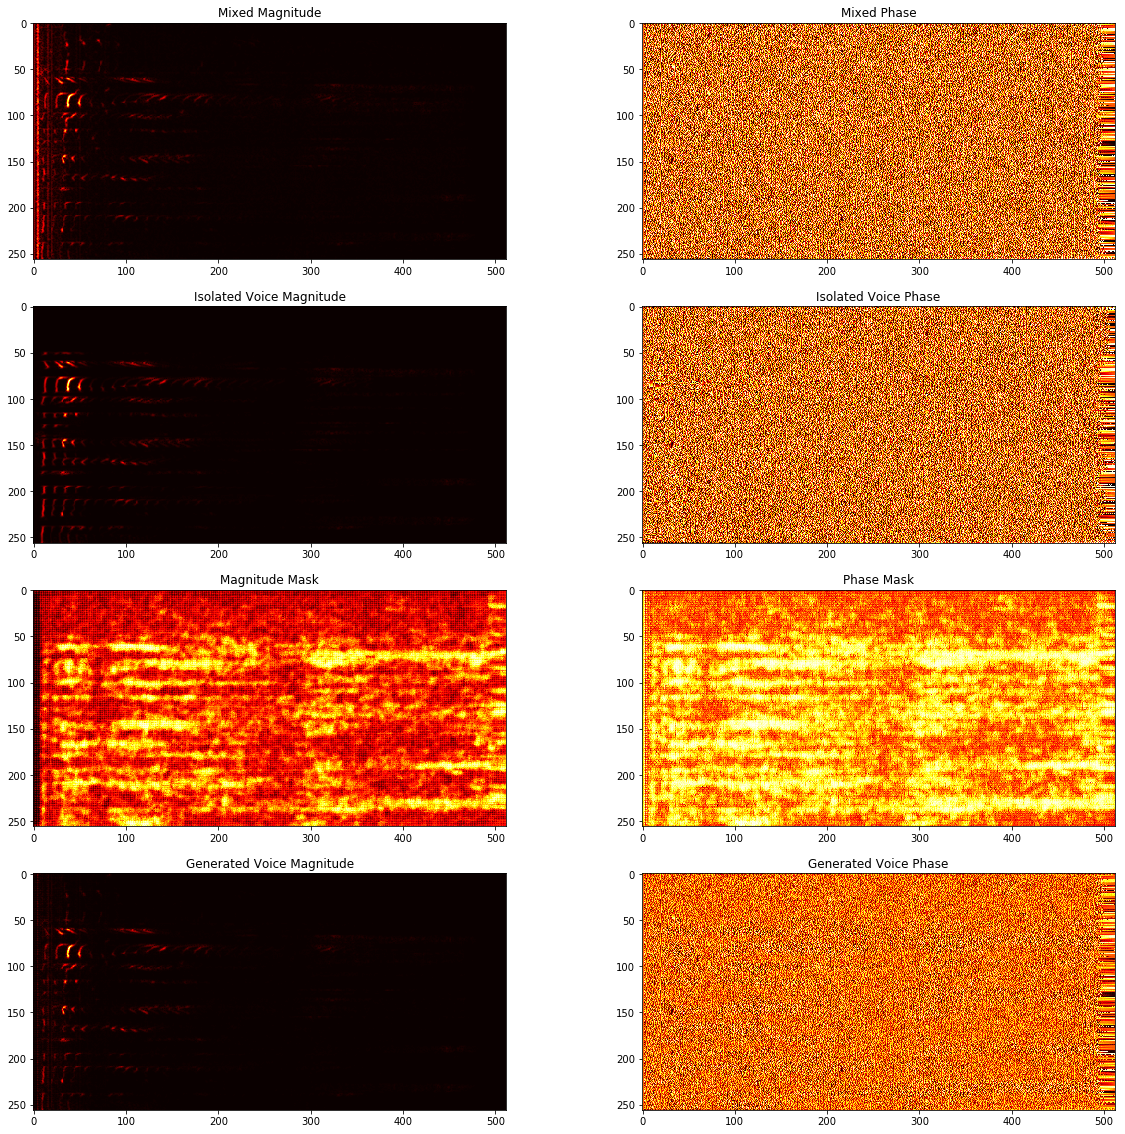

In [20]:
# Plot input and outputs for a magnitude and phase model
i=0

fig, ax = plt.subplots(4,2, figsize=(20,20))

ax[0,0].imshow(mix_inp[i,:,:,0])
ax[0,0].set_title('Mixed Magnitude')
ax[0,1].imshow(mix_inp[i,:,:,1])
ax[0,1].set_title('Mixed Phase')
ax[1,0].imshow(voice_inp[i,:,:,0])
ax[1,0].set_title('Isolated Voice Magnitude')
ax[1,1].imshow(voice_inp[i,:,:,1])
ax[1,1].set_title('Isolated Voice Phase')
ax[2,0].imshow(mask[i,:,:,0])
ax[2,0].set_title('Magnitude Mask')
ax[2,1].imshow(mask[i,:,:,1])
ax[2,1].set_title('Phase Mask')
ax[3,0].imshow(voice_est[i,:,:,0])
ax[3,0].set_title('Generated Voice Magnitude')
ax[3,1].imshow(voice_est[i,:,:,1])
ax[3,1].set_title('Generated Voice Phase')
#plt.savefig(os.path.join(folder, 'mag_phase_example_2.png'))
plt.show()

In [29]:
hist, bins = np.histogram(voice_inp[:,:,:,0], 500)

(array([1.20111e+05, 4.92300e+03, 1.83700e+03, 9.65000e+02, 6.01000e+02,
        4.28000e+02, 3.46000e+02, 2.47000e+02, 2.01000e+02, 1.56000e+02,
        1.46000e+02, 1.12000e+02, 1.05000e+02, 9.10000e+01, 8.40000e+01,
        6.10000e+01, 5.90000e+01, 6.30000e+01, 4.90000e+01, 3.30000e+01,
        4.30000e+01, 3.90000e+01, 4.70000e+01, 1.60000e+01, 2.70000e+01,
        2.20000e+01, 2.30000e+01, 2.00000e+01, 1.70000e+01, 1.30000e+01,
        1.60000e+01, 1.40000e+01, 8.00000e+00, 1.30000e+01, 1.00000e+01,
        1.00000e+01, 3.00000e+00, 6.00000e+00, 5.00000e+00, 5.00000e+00,
        5.00000e+00, 6.00000e+00, 3.00000e+00, 5.00000e+00, 3.00000e+00,
        2.00000e+00, 3.00000e+00, 4.00000e+00, 2.00000e+00, 4.00000e+00,
        1.00000e+00, 5.00000e+00, 1.00000e+00, 2.00000e+00, 1.00000e+00,
        4.00000e+00, 2.00000e+00, 0.00000e+00, 2.00000e+00, 2.00000e+00,
        1.00000e+00, 0.00000e+00, 8.00000e+00, 1.00000e+00, 4.00000e+00,
        3.00000e+00, 2.00000e+00, 1.00000e+00, 0.00

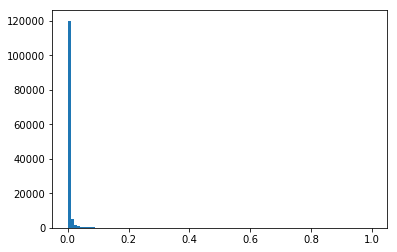

In [38]:
plt.hist(voice_inp[0,:,:,0].flatten(), 100)

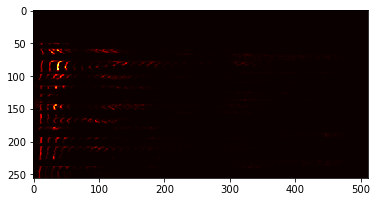

In [39]:
plt.imshow(voice_inp[0,:,:,0])

In [22]:
sess.run(pipe.initializer)
voice = np.squeeze(sess.run(voice_input)[0], axis=2)

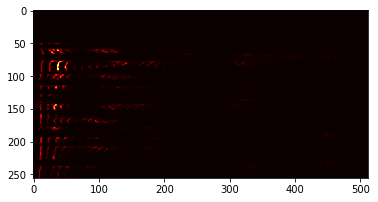

In [23]:
plt.imshow(voice)

In [25]:
import cv2

In [27]:
voice_int = voice*256
voice_int = voice_int.astype(int)

In [26]:
ret, thresh = cv2.threshold(voice_int,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

error: OpenCV(4.0.0) /io/opencv/modules/imgproc/src/thresh.cpp:1389: error: (-215:Assertion failed) src.type() == CV_8UC1 in function 'threshold'


In [29]:
voice_int

array([[0, 0, 1, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [2, 2, 2, ..., 0, 0, 0]])

(array([1.07581e+05, 1.00400e+04, 3.92900e+03, 2.06100e+03, 1.30200e+03,
        9.19000e+02, 6.75000e+02, 5.18000e+02, 4.04000e+02, 3.45000e+02,
        2.72000e+02, 2.39000e+02, 1.95000e+02, 1.86000e+02, 1.38000e+02,
        1.58000e+02, 1.28000e+02, 1.28000e+02, 1.06000e+02, 9.40000e+01,
        8.70000e+01, 7.40000e+01, 7.70000e+01, 7.10000e+01, 5.80000e+01,
        5.50000e+01, 6.10000e+01, 5.50000e+01, 5.00000e+01, 4.00000e+01,
        4.10000e+01, 3.80000e+01, 4.00000e+01, 4.10000e+01, 3.70000e+01,
        2.80000e+01, 3.00000e+01, 3.90000e+01, 2.70000e+01, 1.90000e+01,
        2.90000e+01, 2.90000e+01, 2.10000e+01, 2.30000e+01, 2.10000e+01,
        2.30000e+01, 2.10000e+01, 1.80000e+01, 1.80000e+01, 1.40000e+01,
        1.40000e+01, 1.10000e+01, 2.00000e+01, 1.80000e+01, 1.70000e+01,
        1.30000e+01, 1.20000e+01, 2.00000e+01, 2.00000e+01, 4.00000e+00,
        9.00000e+00, 7.00000e+00, 9.00000e+00, 1.30000e+01, 1.00000e+01,
        1.10000e+01, 5.00000e+00, 1.20000e+01, 7.00

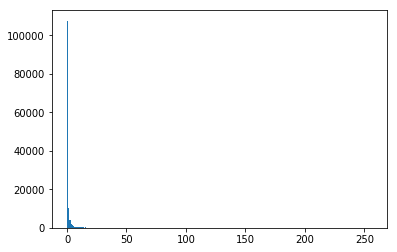

In [30]:
plt.hist(voice_int.flatten(), 256)

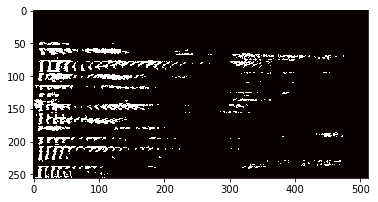

In [41]:
voice_bin = np.where(voice_int>2, 1, 0)
plt.imshow(voice_bin)